In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

# Gradient Boosted Trees

On meta dataset

In [45]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import processed_data_dir

dataset_version = 'v2.1'

input_dir = processed_data_dir / 'meta_data' / dataset_version

## Load Data

In [46]:
train_df = pd.read_csv(input_dir/'train.csv', index_col=0)
test_df = pd.read_csv(input_dir/'test.csv', index_col=0)

print(train_df.shape, test_df.shape)
train_df.head()

(2494, 41) (1074, 41)


,Area,Subregion_3.0,Subregion_1.0,Subregion_4.0,Subregion_2.0,Subregion_5.0,Subregion_6.0,Subregion_0.0,Subregion_7.0,lat,...,Cotton,Dates,Grass,Lucern,Maize,Pecan,Vacant,Vineyard,"Vineyard & Pecan (""Intercrop"")",nn_count
Field_Id,,,,,,,,,,,,,,,,,,,,,
1,0.915905,1,0,0,0,0,0,0,0,22.170005,...,2,0,0,1,0,2,0,4,1,8
2,2.064410,1,0,0,0,0,0,0,0,22.174372,...,0,0,0,1,0,1,0,7,1,13
3,1.080300,1,0,0,0,0,0,0,0,22.172834,...,2,0,0,1,0,2,0,4,1,10
4,1.316190,1,0,0,0,0,0,0,0,22.175138,...,1,0,0,1,0,2,0,5,1,10
7,5.529220,1,0,0,0,0,0,0,0,22.175166,...,0,0,0,1,0,2,0,6,1,12


In [47]:
train_df.index.dtype

dtype('int64')

### Add label from shapefile

In [48]:
from src.utils import read_shapefile

train_shp = read_shapefile('train')

train_df = train_df.join(train_shp['y'], on='Field_Id')

train_df.head()

,Area,Subregion_3.0,Subregion_1.0,Subregion_4.0,Subregion_2.0,Subregion_5.0,Subregion_6.0,Subregion_0.0,Subregion_7.0,lat,...,Dates,Grass,Lucern,Maize,Pecan,Vacant,Vineyard,"Vineyard & Pecan (""Intercrop"")",nn_count,y
Field_Id,,,,,,,,,,,,,,,,,,,,,
1,0.915905,1,0,0,0,0,0,0,0,22.170005,...,0,0,1,0,2,0,4,1,8,Vineyard
2,2.064410,1,0,0,0,0,0,0,0,22.174372,...,0,0,1,0,1,0,7,1,13,Pecan
3,1.080300,1,0,0,0,0,0,0,0,22.172834,...,0,0,1,0,2,0,4,1,10,Vineyard
4,1.316190,1,0,0,0,0,0,0,0,22.175138,...,0,0,1,0,2,0,5,1,10,Vineyard
7,5.529220,1,0,0,0,0,0,0,0,22.175166,...,0,0,1,0,2,0,6,1,12,Vineyard


## Define model static params

* 9 classes
* multi class log loss

In [49]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from xgboost.sklearn import XGBClassifier

X = train_df.drop('y', axis=1)
y = train_df.y

static_params = {
        'objective': 'multi:softprob',
        'num_class': 9,
        'eval_metric': 'mlogloss',
        'seed': 2019,
}

def get_xgb(**params):
    
    xgb_params = {**static_params, **params}

    model = XGBClassifier(**xgb_params)

    return model

## Either: HPO or Skip to found best params below

### Search for hyper parameters

In [50]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold

from IPython.display import clear_output

class ConvergencePlotCallback(object):
    def __init__(self, figsize=(12,8)):
        self.fig = plt.figure(figsize=figsize)

    def __call__(self, res):
        clear_output(wait=True)
        plot_convergence(res)
        plt.show()
        
skf = StratifiedKFold(n_splits=3)
plot_callback = ConvergencePlotCallback(figsize=(12,8));

space = [
    Integer(1, 21, name='max_depth'),
    Real(1e-5, 0.1, "log-uniform", name='learning_rate'),
    Integer(1, 10, name='min_child_weight'),
    Real(1e-5, 10, "log-uniform", name='gamma'),
    Real(0.1, 1.0, "uniform", name="subsample"),
    Real(0.1, 1.0, "uniform", name='colsample_bytree'),
    Real(1e-6, 100, "log-uniform", name="reg_alpha")
]

@use_named_args(space)
def objective(**params):
    
    new_params = {**static_params}
    new_params.update(**params)
    
    model = XGBClassifier(**new_params)
    
    score = -np.mean(cross_val_score(model, X, y, cv=skf, n_jobs=-1, scoring='neg_log_loss'))
    
    return score

def to_named_params(params, space=space):
    return({dimension.name: param for dimension, param in zip(space, params)})

<Figure size 864x576 with 0 Axes>

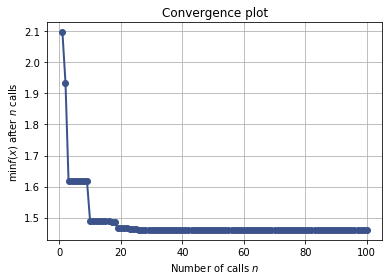

In [51]:
gp_results = gp_minimize(objective, space, n_calls=100, random_state=2019, callback=[plot_callback], n_jobs=-1)

In [97]:
from pprint import pprint

best_params = to_named_params(gp_results.x)
opt_params = {**static_params, **best_params}

print('Best params:')
pprint(best_params)

Best params:
{'colsample_bytree': 0.33475729690415135,
 'gamma': 0.001,
 'learning_rate': 0.0682585781151064,
 'max_depth': 13,
 'min_child_weight': 5,
 'reg_alpha': 1e-05,
 'subsample': 0.781029705398128}


# Skip HPO

If you want to skip HPO, use these params:

In [18]:
from pprint import pprint

best_params = {'colsample_bytree': 0.33475729690415135,
 'gamma': 0.001,
 'learning_rate': 0.0682585781151064,
 'max_depth': 13,
 'min_child_weight': 5,
 'reg_alpha': 1e-05,
 'subsample': 0.781029705398128}

opt_params = {**static_params, **best_params}

print('Best params:')
pprint(opt_params)

Best params:
{'colsample_bytree': 0.33475729690415135,
 'eval_metric': 'mlogloss',
 'gamma': 0.001,
 'learning_rate': 0.0682585781151064,
 'max_depth': 13,
 'min_child_weight': 5,
 'num_class': 9,
 'objective': 'multi:softprob',
 'reg_alpha': 1e-05,
 'seed': 2019,
 'subsample': 0.781029705398128}


## Inspect Model Performance

In [20]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix

from config import raw_data_dir

seed=2019

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

# Create validation set for permutation importance
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)

### Cross Validation Score

In [21]:
cv_scores = cross_val_score(get_xgb(**opt_params), X, y, scoring='neg_log_loss', n_jobs=-1, cv=StratifiedKFold(n_splits=3))

print('Cross validation score: {} (±{})'.format(np.mean(cv_scores)*-1, np.std(cv_scores)*-1))

Cross validation score: 0.8198216914521111 (±-0.011096169021711658)


In [22]:
# Fit model
best_model = get_xgb(**opt_params)
best_model.fit(X_train, y_train)

# Make predicitions ons validation set
val_preds = best_model.predict(X_val)

### Classification Report

In [23]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(y_val, val_preds, labels=class_labels, output_dict=True))

,Cotton,Dates,Grass,Lucern,Maize,Pecan,Vacant,Vineyard,"Vineyard & Pecan (""Intercrop"")",accuracy,macro avg,weighted avg
f1-score,0.761905,0.0,0.206897,0.830325,0.904110,0.481481,0.671429,0.858801,0.100000,0.786859,0.534994,0.758984
precision,0.857143,0.0,0.600000,0.804196,0.880000,0.764706,0.643836,0.787234,1.000000,0.786859,0.704124,0.785374
recall,0.685714,0.0,0.125000,0.858209,0.929577,0.351351,0.701493,0.944681,0.052632,0.786859,0.516517,0.786859
support,35.000000,2.0,24.000000,134.000000,71.000000,37.000000,67.000000,235.000000,19.000000,0.786859,624.000000,624.000000


### Confusion Matrix

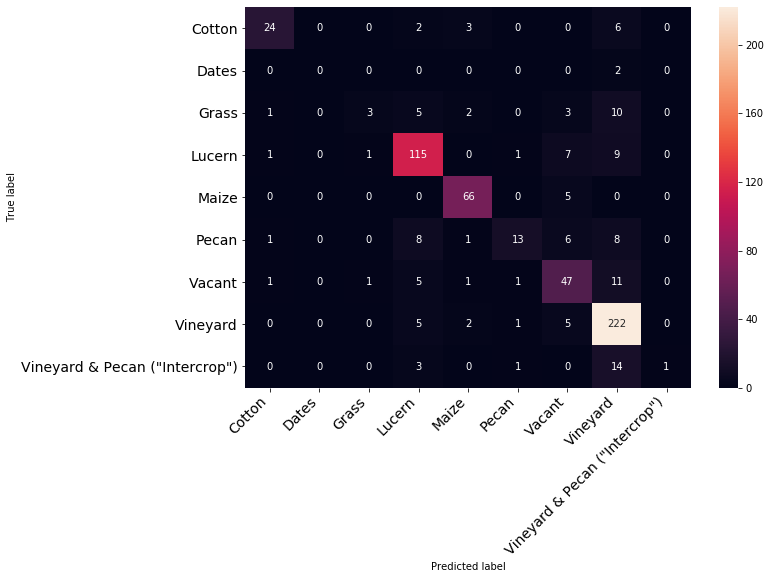

In [24]:
cm = confusion_matrix(y_val, val_preds)
print_confusion_matrix(cm, class_names=class_labels);

### Feature Importances

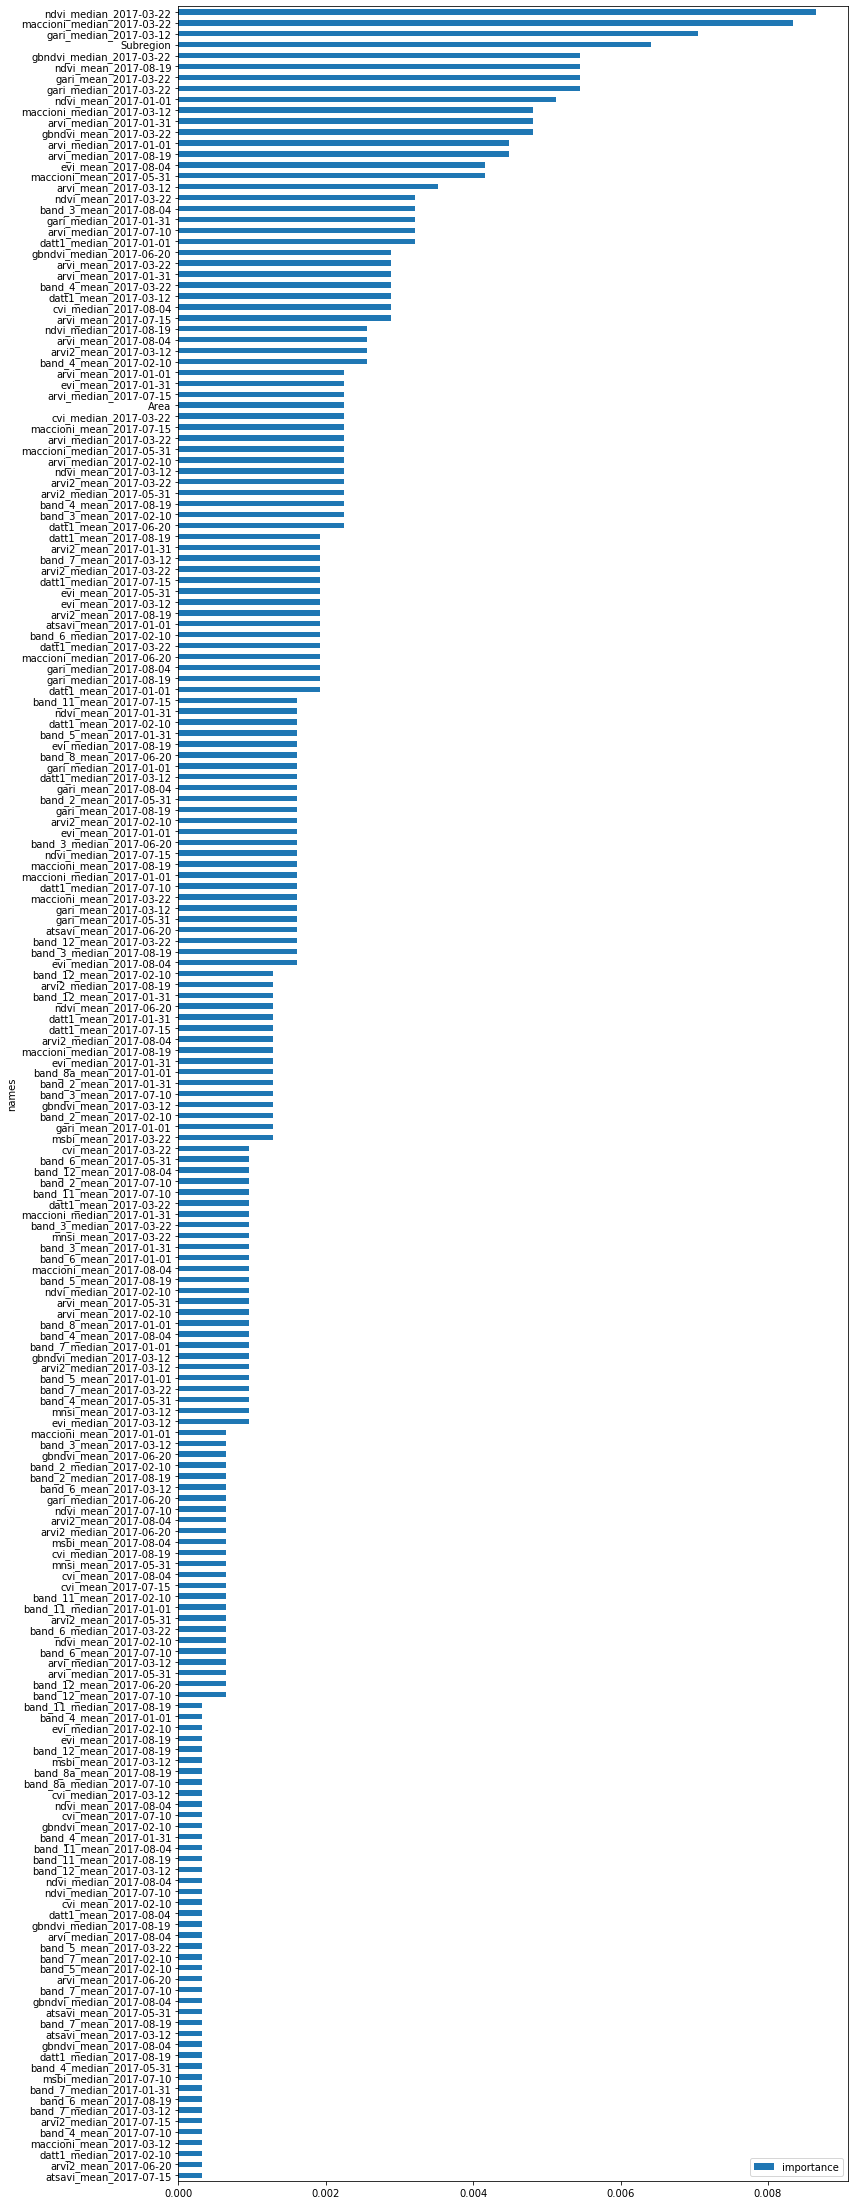

In [25]:
perm = PermutationImportance(best_model, random_state=seed).fit(X_val, y_val)

feat_imp = pd.DataFrame({'importance': perm.feature_importances_, 'names': X.columns}).sort_values(by='importance')

# Show only positive values
feat_imp = feat_imp[feat_imp.importance > 0]

plot = feat_imp.plot.barh(figsize=(12, 40), x='names')

## Make Submission

In [91]:
from config import raw_data_dir, subs_dir

def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')
    
    print(len(new_sub), len(ids_list))

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = best_model.predict_proba(test_df)
test_ids = test_df.index.to_list()

sub_df = make_sub(predictions, test_ids)
sub_df.head()

1074 1074


,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
5,0.019571,0.007821,0.036918,0.069737,0.008211,0.052741,0.018539,0.670766,0.115695
6,0.036144,0.007699,0.053368,0.044214,0.011272,0.069234,0.018883,0.697056,0.062130
10,0.002076,0.000885,0.002319,0.002613,0.001209,0.002967,0.001902,0.910606,0.075424
18,0.003895,0.001747,0.008335,0.003077,0.002935,0.006397,0.005739,0.933805,0.034070
23,0.004271,0.001846,0.006825,0.003447,0.003060,0.006533,0.008044,0.947135,0.018840


In [92]:
sub_df.to_csv(subs_dir / 'xgboost_data_v4_2.csv')